In [21]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  # compute potential density

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

from matplotlib import animation, gridspec

ccrs = cartopy.crs

print('packages check')

packages check


# Create animations for annual anomalies of selected variables from CESM2 model outputs

- Loop through each variable to:
  - Load the dataset and apply longitudinal shift
  - Replace non-finite and masked values
  - Calculate anomalies for specific depth ranges or HMXL
- Define a function to plot data for each time step in the animation
- Set up figure and layout for animation
- Create and save animation for each variable with appropriate colorbar and contour lines

In [11]:
### INITIALISATION

files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

variables = ['TEMP', 'SALT', 'SIGMA_2', 'HMXL', 'SHF', 'SSH']
labels = [r'Temperature Anomaly $\Delta T$ [$^{\circ} C$]', r'Haline Anomaly $Delta S$ [$\frac{g}{kg}$]', r'Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]', r'March Mixed Layer Depth Anomaly $\Delta h$ [$m$]',r'Total Surface Heat Flux Anomaly $\Delta Q_s$ [$\frac{W}{m^2}$]', r'Sea Surface Height Anomaly $\Delta \eta$ [$m$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, cmo.tarn, cmo.balance, cmo.diff]
vmins = [-0.6, -0.2, -0.1, -30000, -40, -0.08]

print('initialisation complete')

initialisation complete


Starting with TEMP
TEMP has been loaded
TEMP animation has been created


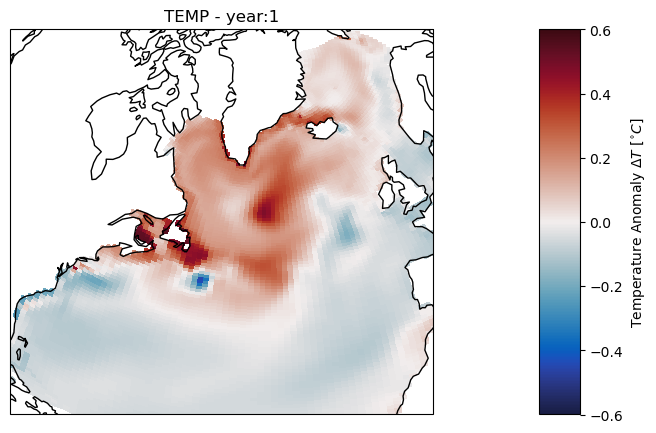

In [27]:
# Create data and make animation
for v in range(len(variables)):
    var = variables[v]
    print('Starting with ' + var)
    
    # Load dataset
    ds_var_annual = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc').roll(nlon=+100)
    
    # Replace non-finite values and masked values
    replacement_value = 0
    ds_var_annual['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds_var_annual['TLAT']), np.isinf(ds_var_annual['TLAT']) | np.ma.getmask(ds_var_annual['TLAT'])),
        replacement_value,
        ds_var_annual['TLAT'])
    ds_var_annual['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds_var_annual['TLONG']), np.isinf(ds_var_annual['TLONG']) | np.ma.getmask(ds_var_annual['TLONG'])),
        replacement_value,
        ds_var_annual['TLONG'])
    
    vmin = vmins[v]
    vmax = -vmin
    
    if var == 'TEMP' or var == 'SALT' or var == 'SIGMA_2':
        ds = ds_var_annual.sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t') - ds_var_annual.isel(time=slice(0,40)).mean('time').sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t')
    elif var == 'HMXL':
        continue
        #ds_var_annual = das_var_annual.roll(nlon=-100)
        #ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    else:
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    
    print(var + ' has been loaded')
     
    # Define plot function for each time step
    def plot_var_frame(time_step):
        data = ds[var].isel(time=start + time_step)
        ax1.cla()
        
        pc = data.plot.pcolormesh(ax=ax1, 
                                transform=ccrs.PlateCarree(),
                                x='TLONG', 
                                y='TLAT',
                                cmap=cmaps[v],
                                vmin = vmin, vmax = vmax,
                                add_colorbar=False,) 
        
        ax1.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
        ax1.coastlines()
  
        ax1.set_title(var + f' - year:{1+time_step}')
    
    # Set up initial data
    start = 1

    # Create figure and set up layout of subplots
    fig = plt.figure(figsize=(8, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[13, 1])
    
    # Main subplot for animation
    ax1 = plt.subplot(gs[0], projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
    
    # Colorbar subplot 
    cax = plt.subplot(gs[1])
    num_time_steps = 59
    ani = animation.FuncAnimation(fig, plot_var_frame, frames=num_time_steps, interval=800)
    
    if var == 'TEMP' or var == 'SALT' or var == 'SIGMA_2':
        contour_levels = np.linspace(-2, 2, 21)  # Adjust levels as needed
        contour = ax1.contour(ds_var_annual[var].isel(time=59).sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t'), 
                              levels=contour_levels, colors='k', linewidths=1.5, zorder=10)
    else:
        contour_levels = np.linspace(-2, 2, 21)  # Adjust levels as needed
        contour = ax1.contour(ds_var_annual[var].isel(time=59), levels=contour_levels, colors='k', linewidths=1.5, zorder=10)
    
    # Set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmaps[v], norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(labels[v])
    
    # Save animation
    ani.save(os.path.expanduser('~/phase1_CONDA/results/') + var + 'annual_anomaly.gif', writer='pillow', fps=3)
    
    print(var + ' animation has been created')
    
    break
